In [2]:
import os
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, concatenate, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Dropout, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
from PIL import Image
import os, glob, sys
import numpy as np
from sklearn.model_selection import train_test_split # 섞어줌
from keras.utils import np_utils

In [5]:
img_dir = '/content/drive/MyDrive/git/raw-img'
categories = ['butterfly','cat','dog','cow']        # chicken -> butterfly
np_classes = len(categories)

image_w = 224
image_h = 224

pixel = image_h * image_w * 3

X=[]
y=[]

for idx, messy_desk in enumerate(categories) : ## 인덱스 값과 벨류 값이 같이나옴 enumerate

    img_dir_detail = img_dir + "/" + messy_desk
    files = glob.glob(img_dir_detail + "/*") ## 파일들이 리스트 형태로 저장된다.

    for i, f in enumerate(files) :
        try :
            img = Image.open(f)
            img = img.convert("RGB")
            img = img.resize((image_w, image_h))
            data = np.asarray(img)
            # Y는 0 아니면 1 이므로 idx 값으로 넣는다.
            X.append(data)
            y.append(idx)
            if i % 300 == 0 :
                print(messy_desk, ":", f)
      
        except :
            print(messy_desk, str(i) + " 번째에서 에러", f)

X = np.array(X)
y = np.array(y)

## train set 0.9, test set 0.1
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)

# ## 전처리 된 파일을 저장한다 : check point 1
xy = (X_train, X_test, y_train, y_test)
np.save('/content/drive/MyDrive/git/butterfly_.npy', xy)

butterfly : /content/drive/MyDrive/git/raw-img/butterfly/OIP-gbkcf5IS3N1tsJBjA3ARpAHaFp.jpeg
butterfly : /content/drive/MyDrive/git/raw-img/butterfly/OIP-MGIU_CQ_uZhbhciDafrCgAHaIr.jpeg
butterfly : /content/drive/MyDrive/git/raw-img/butterfly/OIP-ScrWREtIGYuuXINeHvShcwHaFj.jpeg
butterfly : /content/drive/MyDrive/git/raw-img/butterfly/OIP-y4KpgwUcehzdI2Cw7qBszQHaE8.jpeg
butterfly : /content/drive/MyDrive/git/raw-img/butterfly/ea37b40c28fc083ed1584d05fb1d4e9fe777ead218ac104497f5c97faee9bdba_640.jpg
butterfly : /content/drive/MyDrive/git/raw-img/butterfly/OIP-3YV7EmpW4ox9Ysakv7l3LAHaFK.jpeg
butterfly : /content/drive/MyDrive/git/raw-img/butterfly/OIP-c6HXAxqPJ2QAzckbaLF6FgHaF8.jpeg
butterfly : /content/drive/MyDrive/git/raw-img/butterfly/ea34b90b2bf7063ed1584d05fb1d4e9fe777ead218ac104497f5c97faee9bdba_640.jpg
cat : /content/drive/MyDrive/git/raw-img/cat/1880.jpeg
cat : /content/drive/MyDrive/git/raw-img/cat/6.jpeg
cat : /content/drive/MyDrive/git/raw-img/cat/ea34b20c2ef6013ed1584d05fb1d4e

/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [6]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

print(X_train.shape)        
print(X_train.shape[0])    
print(np.bincount(y_train)) 
print(np.bincount(y_test))  

(8208, 224, 224, 3)
8208
[1897 1509 3133 1669]
[215 159 341 197]


In [7]:
# resNet 모델 작성
def model_res():

    # F(X) = F(X) + X
    def indentity_block(X, f, filters):
        
        # 필터 갯수
        F1, F2, F3 = filters

        # X 저장 
        X_shortcut = X

        # F(X)
        # 첫번째 conv layer
        X = Conv2D(F1, (1, 1), strides = (1, 1), padding = 'valid')(X)
        X = layers.BatchNormalization(axis = 3)(X)
        X = layers.Activation('relu')(X)

        # 두번쨰 conv layer
        X = Conv2D(F2, (f, f), strides = (1, 1), padding = 'same')(X)
        X = layers.BatchNormalization(axis = 3)(X)
        X = layers.Activation('relu')(X)

        # 세번째 conv layer
        X = Conv2D(F3, (1, 1), strides = (1, 1), padding = 'valid')(X)
        X = layers.BatchNormalization(axis = 3)(X)

        # F(X) + X
        # 첫번째와 세번째는 1x1이고 두번째는 padding이 same 이므로 shape는 동일하다.
        X = layers.Add()([X, X_shortcut])
        X = layers.Activation('relu')(X)

        return X

    # F(X) = F(X) + G(X) : 숏컷 적용 레이어
    def Conv_Block(X, f, filters, s = 2):
        
        # 필터 갯수
        F1, F2, F3 = filters

        # X 저장
        X_shortcut = X

        # F(X)
        # 첫번째 conv layer
        X = Conv2D(F1, (1, 1), strides = (s, s), padding = 'valid')(X)
        X = layers.BatchNormalization(axis = 3)(X)
        X = layers.Activation('relu')(X)

        # 두번쨰 conv layer
        X = Conv2D(F2, (f, f), strides = (1, 1), padding = 'same')(X)
        X = layers.BatchNormalization(axis = 3)(X)
        X = layers.Activation('relu')(X)

        # 세번째 conv layer
        X = Conv2D(F3, (1, 1), strides = (1, 1), padding = 'valid')(X)
        X = layers.BatchNormalization(axis = 3)(X)
        
        # G(X) 
        # shortcut layer
        X_shortcut = Conv2D(F3, (1, 1), strides = (s, s), padding= 'valid')(X_shortcut)   
        X_shortcut = layers.BatchNormalization(axis = 3)(X_shortcut)

        # F(X) + G(X)
        X = layers.Add()([X, X_shortcut])
        X = layers.Activation('relu')(X)

        return X 

    # resNet50 은 다음과 같은 구조를 갖는다.
    # 0. (3,3) 제로 패딩
    # 1. Conv2D 사용. s = 2인 7x7 크기 필터 64개, 배치 정규화, relu 사용, MaxPooling 사용
    # 2. Conv_Block 사용. s = 1인 3x3 크기 필터 64x64x256개 사용
    #    indentity_block 2번 사용. 3x3 크기 필터 64x64x256개 사용
    # 3. Conv_Block 사용. s = 2인 3x3 크기 필터 128x128x512개 사용
    #    indentity_block 2번 사용. 3x3 크기 필터 128x128x512개 사용
    # 4. Conv_Block 사용. s = 2인 3x3 크기 필터 256x256x1024개 사용
    #    indentity_block 2번 사용. 3x3 크기 필터 256x256x1024개 사용
    # 5. Conv_Block 사용. s = 2인 3x3 크기 필터 512x512x2048개 사용
    #    indentity_block 2번 사용. 3x3 크기 필터 256x256x1024개 사용
    # 6. AveragePooling 사용. 2x2
    # 7. Dense layer

    input_img = Input((224, 224, 3))

    # 0. (3,3) 제로 패딩
    # 1. Conv2D 사용. s = 2인 7x7 크기 필터 64개, 배치 정규화, relu 사용, MaxPooling 사용
    X = Conv2D(64, (7, 7), strides = (2, 2), padding = "same")(input_img)
    X = layers.BatchNormalization(axis = 3)(X)
    X = layers.Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides = (2, 2))(X)

    # 2. Conv_Block 사용. s = 1인 3x3 크기 필터 64x64x256개 사용
    #    indentity_block 2번 사용. 3x3 크기 필터 64x64x256개 사용
    X = Conv_Block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = indentity_block(X, 3, [64, 64, 256])
    X = indentity_block(X, 3, [64, 64, 256])

    # 3. Conv_Block 사용. s = 2인 3x3 크기 필터 128x128x512개 사용
    #    indentity_block 2번 사용. 3x3 크기 필터 128x128x512개 사용
    X = Conv_Block(X, 3, [128, 128, 512])
    X = indentity_block(X, 3, [128, 128, 512])
    X = indentity_block(X, 3, [128, 128, 512])

    # 4. Conv_Block 사용. s = 2인 3x3 크기 필터 256x256x1024개 사용
    #    indentity_block 5번 사용. 3x3 크기 필터 256x256x1024개 사용
    X = Conv_Block(X, 3, [256, 256, 1024])
    X = indentity_block(X, 3, [256, 256, 1024])
    X = indentity_block(X, 3, [256, 256, 1024])
    X = indentity_block(X, 3, [256, 256, 1024])
    X = indentity_block(X, 3, [256, 256, 1024])
    X = indentity_block(X, 3, [256, 256, 1024])

    # 5. Conv_Block 사용. s = 2인 3x3 크기 필터 512x512x2048개 사용
    #    indentity_block 2번 사용. 3x3 크기 필터 256x256x1024개 사용
    X = Conv_Block(X, 3, [512, 512, 2048])
    X = indentity_block(X, 3, [512, 512, 2048])
    X = indentity_block(X, 3, [512, 512, 2048])

    # 6. AveragePooling 사용. 2x2
    X = AveragePooling2D(2, 2)(X)

    # 7. Dense layer
    X = Flatten()(X)
    out = Dense(4, activation="softmax")(X)

    model = Model(inputs = input_img, outputs = out)

    return model


In [8]:
model_res().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10) 

model = model_res() 
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
history = model.fit(X_train, y_train, callbacks=[early_stopping], batch_size=50, validation_data = (X_test,y_test), epochs = 100)

Epoch 1/100
165/165 [==============================] - 83s 477ms/step - loss: 2.0693 - accuracy: 0.5256 - val_loss: 1.5352 - val_accuracy: 0.3070
Epoch 2/100
165/165 [==============================] - 78s 470ms/step - loss: 0.9683 - accuracy: 0.6340 - val_loss: 1.5177 - val_accuracy: 0.4518
Epoch 3/100
165/165 [==============================] - 78s 470ms/step - loss: 1.1311 - accuracy: 0.6165 - val_loss: 1.9220 - val_accuracy: 0.4419
Epoch 4/100
165/165 [==============================] - 78s 471ms/step - loss: 0.7935 - accuracy: 0.6834 - val_loss: 0.8979 - val_accuracy: 0.6349
Epoch 5/100
165/165 [==============================] - 78s 470ms/step - loss: 0.7201 - accuracy: 0.7038 - val_loss: 0.9537 - val_accuracy: 0.5976
Epoch 6/100
165/165 [==============================] - 78s 470ms/step - loss: 0.6522 - accuracy: 0.7364 - val_loss: 1.0891 - val_accuracy: 0.5482
Epoch 7/100
165/165 [==============================] - 78s 471ms/step - loss: 0.5923 - accuracy: 0.7534 - val_loss: 1.1521 -

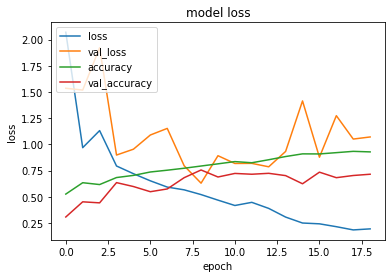

In [14]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss', "accuracy", 'val_accuracy'], loc='upper left')
plt.show()